# Исследование надёжности заёмщиков

**Заказчик** - кредитный отдел банка. 

**Цель исследования** - оценить способность потенциального заёмщика вернуть кредит банку, а также выяснить, влияет ли семейное положение и количество детей клиента на факт погашения заёмныъ средств в срок. На основе статистики о платёжеспособности клиентов в процессе исследования необходимо проверить следующие гипотезы:
1. Чем больше детей в семье, тем меньше вероятность возврата кредита в срок
2. Люди, проживающие в браке, имеют вероятность не вернуть кредит в срок больше, чем люди, которые не проживают в браке
3. Чем ниже уровнь дохода, тем ниже веростность возврата кредита в срок
4. Разные цели кредита по-разному влияют на его возврат в срок

**Ход исследования:** данные о платёжеспособности клиентов будут получены из файла `data.csv`. О качестве данных ничего не известно, поэтому перед проверкой гипотез понадобится проверить данные на качество и наличие в них различных ошибок, пропусков и аномалий. Также будет оценено влияние ошибок на исследование. Затем, на этапе предобработки будут исправлены самые критичные ошибки.

Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.
 
Таким образом, исследование пройдёт в три этапа:
 1. Обзор данных.
 2. Предобработка данных.
 3. Исследовательский анализ данных.
 4. Итоговый вывод

## 1. Обзор данных
На данном этапе будет сформирована первая картина о данных, с которыми предстоит работать дальше. 

In [1]:
# Подключение библиотек 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-dark')
# Устанавливаем дополнительные настройки отображения данных в таблице (округление чисел до двух знаков после запятой)
pd.set_option('display.float_format', '{:.2f}'.format) 

In [2]:
# Чтение файла data.csv и сохранение его в переменной df
try:
    df = pd.read_csv('data.csv')
except:
    df = pd.read_csv('/datasets/data.csv')

In [3]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.67,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.64,покупка жилья
1,1,-4024.80,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.01,приобретение автомобиля
2,0,-5623.42,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.95,покупка жилья
3,3,-4124.75,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.55,дополнительное образование
4,0,340266.07,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.08,сыграть свадьбу


In [4]:
# Получаем общую картину о данных датасета
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Итак, в таблице 12 столбцов. Тип данных в столбцах — `object`,`float64` и `int64 ` 

Согласно документации к данным:
* `children` — количество детей в семье;
* `days_employed` — общий трудовой стаж в днях; 
* `dob_years` — возраст клиента в годах;
* `education` — уровень образования клиента;
* `education_id` — идентификатор уровня образования;
* `family_status` — семейное положение;
* `family_status_id` — идентификатор семейного положения;
* `gender` - пол клиента;
* `income_type` - тип занятости;
* `debt` - имел ли задолженность по возврату кредитов;
* `total_income` - ежемесячный доход;
* `purpose` - цель получения кредита;

Названия колонок написаны без нарушения стиля. Однако количество значений в столбцах различается, следовательно, в данных есть пропущенные значения. 

Также, необходимо заметить, что в колонке `days_employed` некоторые значения отрицательны, но трудовой стаж не может быть выражен подобным образом.

**Вывод**

В каждой строке таблицы — информация о клиенте. Один столбец -`purpose`- описывает сам кредит: то, на что были предоставлены средства банком. Остальные данные рассказывают о заёмщике: его трудовой стаж, ежемесячную зарплату, пол, семейное положение и тд. 

Предварительно можно утверждать, что предоставленных данных достаточно для проверки поставленных гипотез. Но встречаются пропуски в данных, которые необходимо проанализировать и устранить, прежде чем двигаться дальше. 

## 2. Предобработка данных
На данном этапе будут устранены выявленные проблемы в данных.

### 2.1. Обработка аномальных значений

В столбце `days_employed` видны аномалии, которые выражаются в отрицательных значениях. Так как трудавой стаж не может быть выражен отрицательным числом, необходимо эти данные обработать

In [5]:
# Исключим отрицательные значения в столбце days_employed
df['days_employed'] = df['days_employed'].abs()
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.67,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.64,покупка жилья
1,1,4024.80,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.01,приобретение автомобиля
2,0,5623.42,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.95,покупка жилья
3,3,4124.75,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.55,дополнительное образование
4,0,340266.07,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.08,сыграть свадьбу


Для изучения распределения количественных столбцов лучше всего подойдет метод `describe()`

In [6]:
# Смотрим на описательную характеристику количественных данных
df[['children', 'days_employed', 'dob_years', 'total_income']].describe()

,children,days_employed,dob_years,total_income
count,21525.00,19351.00,21525.00,19351.00
mean,0.54,66914.73,43.29,167422.30
std,1.38,139030.88,12.57,102971.57
min,-1.00,24.14,0.00,20667.26
25%,0.00,927.01,33.00,103053.15
50%,0.00,2194.22,42.00,145017.94
75%,1.00,5537.88,53.00,203435.07
max,20.00,401755.40,75.00,2265604.03


Моменты, которые нужно проанализировать и при необходимости исправить:
- Максимальный трудовой стаж в столбце равен более 400 000 дней. Конечно же это нереальное значение
- В столбце с количеством детей есть отрицательные значения, а также максимальное значение - 20
- Минимальный возраст клиента равен нулю

In [7]:
income_df = df.groupby('income_type')[['days_employed']].mean()
income_df

,days_employed
income_type,
безработный,366413.65
в декрете,3296.76
госслужащий,3399.90
компаньон,2111.52
пенсионер,365003.49
предприниматель,520.85
сотрудник,2326.50
студент,578.75


In [8]:
def plotting_income_type(df):
    (df.sort_values(by='days_employed', ascending=False)
       .plot(kind='bar', figsize=(12,5), grid=True, legend=False)
    )
    plt.title('Общий трудовой стаж в разрезе типа занятости')
    plt.xlabel('Тип занятости')
    plt.ylabel('Трудовой стаж, дней')
    plt.xticks(rotation=360);

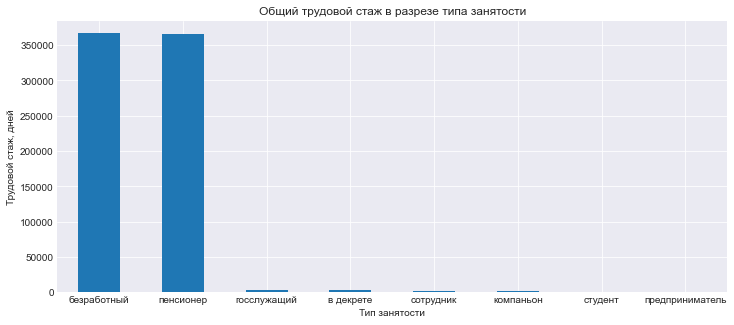

In [9]:
plotting_income_type(income_df)

Мы нашли среднее значение по каждой категории заёмщиков. Видно, что аномальные значения преимущественно принадлежат категориям `безработные` и `пенсионер`, поэтому необходимо капнуть немного глубже именно в эти категории. 

Исходя из полученных средних по каждой категории, выдвину гипотезу: данные по этим столбцам записаны не в днях, а часах. 

In [10]:
# Проверим гипотезу, переведя значения столбца из дней в часы
df.loc[df['income_type'] == 'пенсионер', 'days_employed'] = df['days_employed'] / 24

In [11]:
# Проверим выполнение кода
income_df = df.groupby('income_type')[['days_employed']].mean()
income_df

,days_employed
income_type,
безработный,366413.65
в декрете,3296.76
госслужащий,3399.90
компаньон,2111.52
пенсионер,15208.48
предприниматель,520.85
сотрудник,2326.50
студент,578.75


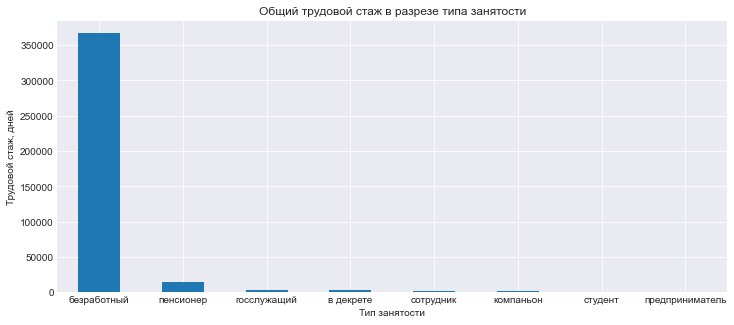

In [12]:
plotting_income_type(income_df)

Проверив гипотезу, мы видим, что среднее значение по столбцу уменьшилось и уже больше похоже на правду. Однако всё равно значительно отличается от среднего значения по всем категориям. 

In [13]:
# Тоже самое проделаем с другим аномальным столбцом
df.loc[df['income_type'] == 'безработный', 'days_employed'] = df['days_employed'] / 24

In [14]:
# Проверим, что из этого вышло
income_df = df.groupby('income_type')[['days_employed']].mean()
income_df

,days_employed
income_type,
безработный,15267.24
в декрете,3296.76
госслужащий,3399.90
компаньон,2111.52
пенсионер,15208.48
предприниматель,520.85
сотрудник,2326.50
студент,578.75


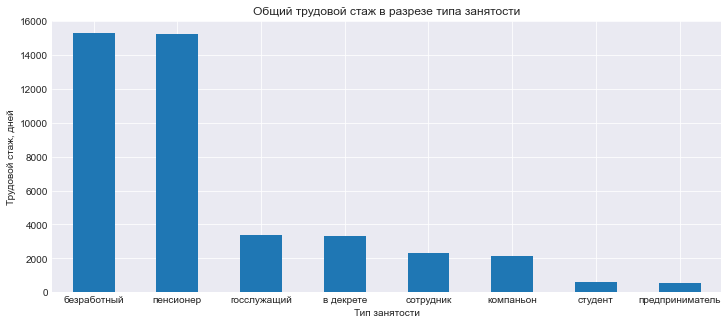

In [15]:
plotting_income_type(income_df)

Здесь мы также наблюдаем сильное изменение в данных, которое уже больше похоже на правду. 

Однако замечу, что, если по столбцу `пенсионер`, выдвигаемую гипотезу можно подтвердить (полученное среднее значение в данной категории на практике может быть получено, потому что про пенсоинера понятно, что человек работает большую часть жизни), то для столбца `безработный` данную гипотезу подтвердить не можем, так как не знаем, кто именно входит в эту категорию и какой возраст в этой категории преобладает. 

Если говорить в целом про столбец `days_employed`, то данные очень плохие и следует вернуть эти данные с целью их доработки и приведения в нормальный вид. На данном этапе оставим данные в таком виде. 

Что касается столбца `children`, то здесь также наблюдаются аномалии и ошибки. 

Во-первых, количество детей не может быть выражено отрицательным числом. Во-вторых, число детей в количестве 20 человек, это тоже очень странно, этот момент нужно проработать.

In [16]:
# Уберём из столбца отрицательные значения
df['children'] = df['children'].abs()

In [17]:
# Посмотрим на то, какое количество детей в семье преобладает
(df.groupby('children')[['children']].count()
                                     .rename(columns={'children':'cnt'})
                                     .reset_index()
)

,children,cnt
0,0,14149
1,1,4865
2,2,2055
3,3,330
4,4,41
5,5,9
6,20,76


Мы видим, что основное количество детей у заёмщиков варьируется в диапазоне от 0 до 5. Дальше заметен сильный скачок до 20 и промежуточных значений от 6 до 19 нет. Следовательно, можно утверждать, что количество детей равное 20 - аномалии, которые необходимо либо удалить, либо предположить, что вместо числа 2, было записано число 20 и обработать соответствующим образом. 

In [18]:
# Найдем долю этой аномалии
len(df[df['children'] == 20]) / len(df)

0.0035307781649245064

Исходя из расчётов, видно, что доля аномальных значений в столбце `children` очень мала, следовательно, эти строки можно обработать одним из двух способом, названных ранее, но в любом случае, на результат исследования не повляет. 

In [19]:
# Перезаписываем датасет 
df = df.loc[df['children'] != 20]

In [20]:
# Проверяем корректность написанного кода
df['children'].max()

5

Видим, что аномалии в столбце `children` обработаны и устранены

Далее необходимо проанализировать возраст заёмщиков, так как в данных также видим некорректные значения в виде нулевого возраста. Доля таких значений также мала, поэтому, исключив эти значения из таблицы, ничего критичного не произойдёт.  

In [21]:
# Группируем по возрасту и находим количество
df.groupby('dob_years')['dob_years'].count().head()

dob_years
0     100
19     14
20     51
21    110
22    183
Name: dob_years, dtype: int64

In [22]:
# Исключаем аномальные значения
df = df.loc[df['dob_years'] != 0]

In [23]:
# Проверяем корректность отработанного кода
df.groupby('dob_years')['dob_years'].count().head()

dob_years
19     14
20     51
21    110
22    183
23    253
Name: dob_years, dtype: int64

Аномалия в столбце `dob_years` обработана и исключина из датафрейма

### 2.2. Обработка пропущенных значений

In [24]:
# Смотрим на количество пропущенных значений в разрезе каждого столбца
df.isna().sum()

children               0
days_employed       2155
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2155
purpose                0
dtype: int64

В столбцах, в которых были обнаружены пропуски, находятся количественные переменные. Поэтому, чтобы заполнить пропуски в данных столбцах, необходимо для каждого типа занятости, посчиатать медианное значение в столбцах `days_employed` и `total_income`, после чего заменить этим числом пропуски в соответствующей строке. 

Так как количество пропусков в обеих столбцах равно, то найдем пропуски для одного столбца и приравняем полученный результат к другому столбцу. После чего с нахождением доли сделаем то же самое (доля пропущенных значений у одного столбца будет равна доле пропусков в другом столбце)

In [25]:
# В столбце days_employed видны аномалии, которые выражаются в отрицательных значениях. Так как трудавой стаж не может быть 
# выражен отрицательным числом, необходимо эти данные обработатьНахождение количества пропусков в столбце про трудавой стаж
share_days = df['days_employed'].duplicated().sum() 
print('Количество пропусков в столбцах про трудовой стаж и доход заёмщика составляют:', share_days)

Количество пропусков в столбцах про трудовой стаж и доход заёмщика составляют: 2154


In [26]:
# Нахождение доли пропусков в объёме данных по столбцу
final_share = share_days / len(df['days_employed'])
print(f'Доля пропусков в столбцах про трудовой стаж и доход заёмщика составляет: {final_share:.2%}')

Доля пропусков в столбцах про трудовой стаж и доход заёмщика составляет: 10.09%


**Возможные причины появления пропусков в данных:** 
1. Человеческий фактор (например, человек просматривал данные, пытался проанализировать выборку и случайно удалил некоторые ячейки). Человеку свойственно ошибаться, именно поэтому при внесении данных, он может опечататься, указать другой формат или тип данных, перепутать числа или категориальные значения.
2. Технологический фактор (при выгрузке данных из БД, произошёл какой-либо сбой и некоторые данные либо не выгрузились, либо удалились (пропали)
3. Ошибки также могли возникнуть при копировании, считывании, смене формата данных.

Далее, напишем функцию, которая заменит пропуски в столбцах `days_employed` и `total_income`, заполнив их медианными значениями в разрезе `income_type`: для каждого `income_type` посчитаем медианный `total_income` и заполним пропуски этим значением. Так мы не усредним данные и меньше повлияем на распределение

In [27]:
# Функция, которая заменяет пропуски в определённом столбце на медианное значение относительно типа занятости
def fill_passes(column):
    for category in df['income_type'].unique():
        df_fill = df[df['income_type'] == category]
        median_number = df_fill[column].median()
        df[column] = df[column].fillna(median_number)

In [28]:
# Заменяем пропуски в столбцах days_employed и total_income
fill_passes('days_employed')
fill_passes('total_income')

In [29]:
# Убедимся в том, что в таблице не осталось пропущенных значений
df.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

**Вывод**

Я считаю, что заполнять пропуски в количественных переменных медианным значением лучшего всего, потому что данная цифра отражает наиболее приближенную картину к тем данным, что находятся в столбце.

Во-первых, мы не знаем, есть ли аномалии в данных, и если они присутствуют и мы выберем среднее значение по столбцу для заполнения пропусков, а не медианное, то дальнейший анализ исказиться, так как средний показатель слишком сильно реагирует на артефакты, которые не отражают реальной картины, что в последствие приведёт к неточному результату. 

Во-вторых, оставлять строчки, ячейки с количественными переменными не заполненными, неправильно, так как это также может повлиять на анализ данных и поспособствует неправильным выводам. Точно также неправильно и удалять полностью строки с пропущенными значениями, так как можно лишиться нужных для анализа данных. 

Следовательно, медианное значение по нужному столбцу в разрезе типа занятости самое приближенное значение данным выборки, и пропуски количественных переменных были заполнены наиболее верным способом. 

### 2.3. Замена вещественного типа данных на целочисленный

Заменим вещественный тип данных в столбце `total_income` на целочисленный для того, чтобы со значениями столбца можно было работать корректно.

In [30]:
df['total_income'] = df['total_income'].astype('int')

In [31]:
# Проверяем корректность замены
df['total_income'].dtype

dtype('int64')

### 2.4. Поиск и устранение дубликатов

Теперь таблицу необходимо проанализировать на наличие явных дубликатов.

In [32]:
df.duplicated().sum()

54

In [33]:
# Избавляемся от найденных дубликатов
df = df.drop_duplicates() 

In [34]:
# Проверим то, как отработал метод
df.duplicated().sum()

0

Далее необходимо проанализировать данные на наличие уже неявных дубликатов. 

In [35]:
df['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

Можно заметить, что в этом столбце присутсвуют неявные дубликаты: одни и те же значения, записанные по-разному: с использованием заглавных и строчных букв. Эти значения нужно обработать - привести их к единому регистру.

In [36]:
df['education'] = df['education'].str.lower()

In [37]:
# Проверяем, как справился выбранный метод с задачей
df['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

Далее проверим другие столбцы с категориальными значениями на наличие неявных дубликатов

In [38]:
df['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

В данном столбце неявные дубликаты не просматриваются, но есть одно замечание к записи: одна категория записана с заглавной буквы, что в дальнейшем может привести к путанице. Для удобства все категории также приведём к одному регистру.

In [39]:
df['family_status'] = df['family_status'].str.lower()

In [40]:
df['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'не женат / не замужем'], dtype=object)

In [41]:
df['gender'].unique()

array(['F', 'M', 'XNA'], dtype=object)

Присутствие в данных `XNA` - аномалия, следовательно, необходимо посмотреть на это подробнее

In [42]:
# Нахождение количества человек по их полу
df.groupby('gender')['gender'].count()

gender
F      14071
M       7223
XNA        1
Name: gender, dtype: int64

Из расчёта видно, что выброс в виде "XNA" в столбце `gender` найден всего один, поэтому его можно безболезненно удалить. 

In [43]:
# Удалим данный выброс из данных
df = df.loc[df['gender'] != 'XNA']

In [44]:
# Проверим, получилось ли обработать данные
df.groupby('gender')['gender'].count()

gender
F    14071
M     7223
Name: gender, dtype: int64

In [45]:
df['income_type'].unique()

array(['сотрудник', 'пенсионер', 'компаньон', 'госслужащий',
       'безработный', 'предприниматель', 'студент', 'в декрете'],
      dtype=object)

В этом столбце неявные дубликаты не обнаружены

In [46]:
df['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

В данном столбце прослеживается много однородных категорий, которые имеют одним смысл, но записаны по-разному, но я думаю, что для данного столбца это нормально и изменять здесь ничего не надо. 

**Вывод**

Что касается предобработки данных, то были проанализированы и при необходимости обработаны:
- Аномальные значения 
- Пропуски в данных
- Типы данных
- Дубликаты (явные и неявные)

Также можно сказать, что основные причины возникновения дубликатов — повторные представления данных, неправильное соединение данных из разных источников, ошибки пользователя при занесении информации.

## 3. Исследовательский анализ данных

### 3.1. Создание вспомогательных словарей для основного датафрейма
Продолжая работу, в исходном датасете видим, что из данных можно сделать некий словарь, по ключу которого будем подтягивать наши данные. Для этого необходимо создать два новых датафрейма, что сделает изначальную таблицу компактнее, а с данными будет легче работать. В общем, цель этого пункта - сформировать таблицы, в которых будут лежать уникальные связки `id` с значениями `тип образования` и `семейный статус`. 

В первом датасете названия столбцов - `education_id` и `education`; во втором - `family_status_id` и `family_status`.

In [47]:
# Создаём два датафрейма, которые в дальнейшем будут служить словарями
education_dict = df[['education_id', 'education']]
family_status_dict = df[['family_status_id', 'family_status']]

In [48]:
education_dict = education_dict.drop_duplicates().reset_index(drop=True)
education_dict

,education_id,education
0,0,высшее
1,1,среднее
2,2,неоконченное высшее
3,3,начальное
4,4,ученая степень


In [49]:
family_status_dict = family_status_dict.drop_duplicates().reset_index(drop=True)
family_status_dict

,family_status_id,family_status
0,0,женат / замужем
1,1,гражданский брак
2,2,вдовец / вдова
3,3,в разводе
4,4,не женат / не замужем


Так как выше было создано два датафрейма, благодаря которым в любой необходимый момент можно подтянуть информацию о семейном статусе или образовании, следовательно, в исходном датафрейме можем удалить столбцы `education` и `family_status`, так как при необходимости, эти значения будут лежать в словаре `education_dict` и `family_status_dict` соответственно

In [50]:
# Из исходного датафрейма удаляем столбцы education и family_status
df.pop('education')
df.pop('family_status')

0         женат / замужем
1         женат / замужем
2         женат / замужем
3         женат / замужем
4        гражданский брак
               ...       
21520    гражданский брак
21521     женат / замужем
21522    гражданский брак
21523     женат / замужем
21524     женат / замужем
Name: family_status, Length: 21294, dtype: object

In [51]:
# Проверяем то, как справился метод и удалил столбцы
df.head()

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.67,42,0,0,F,сотрудник,0,253875,покупка жилья
1,1,4024.80,36,1,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623.42,33,1,0,M,сотрудник,0,145885,покупка жилья
3,3,4124.75,32,1,0,M,сотрудник,0,267628,дополнительное образование
4,0,14177.75,53,1,1,F,пенсионер,0,158616,сыграть свадьбу


### 3.2. Создание вспомогательных столбцов с категориями

In [52]:
# Функция для проставления категории относительно дохода
def income_category(number):
    try:
        total = number['total_income']
        if 0 <= total <= 30000:
            return 'E'
        elif 30001 <= total <= 50000:
            return 'D'
        elif 50001 <= total <= 200000:
            return 'C'
        elif 200001 <= total <= 1000000:
            return 'B'
        elif total >= 1000001:
            return 'A'
        else:
            return 'ошибка'
    except:
        return 'ошибка'
# Создаём новый столбец и передаём методу apply собственную функцию
df['total_income_category'] = df.apply(income_category, axis=1)

In [53]:
df.head()

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category
0,1,8437.67,42,0,0,F,сотрудник,0,253875,покупка жилья,B
1,1,4024.80,36,1,0,F,сотрудник,0,112080,приобретение автомобиля,C
2,0,5623.42,33,1,0,M,сотрудник,0,145885,покупка жилья,C
3,3,4124.75,32,1,0,M,сотрудник,0,267628,дополнительное образование,B
4,0,14177.75,53,1,1,F,пенсионер,0,158616,сыграть свадьбу,C


In [54]:
# Проверяем, нет ли ошибок в созданном столбце
df['total_income_category'].unique()

array(['B', 'C', 'D', 'E', 'A'], dtype=object)

Видим, что пропусков в новом столбце нет, тем самым, убедились в том, что созданная функция отработала корректно

In [55]:
# Функция для категоризации данных в зависимости от цели кредита
def goal_category(number):
    try:
        loan = number['purpose']
        if 'автомоб' in loan:
            return 'операции с автомобилем'
        elif 'недвижим' in loan:
            return 'операции с недвижимостью'
        elif 'свадьб' in loan:
            return 'проведение свадьбы'
        elif 'образован' in loan:
            return 'получение образования'
        elif 'жиль' in loan:
            return 'покупка жилья'
        else:
            return 'ошибка'
    except:
        return 'ошибка'
# Создаём новый столбец и передаём методу apply собственную функцию 
df['purpose_category'] = df.apply(goal_category, axis=1)

In [56]:
df.head()

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category,purpose_category
0,1,8437.67,42,0,0,F,сотрудник,0,253875,покупка жилья,B,покупка жилья
1,1,4024.80,36,1,0,F,сотрудник,0,112080,приобретение автомобиля,C,операции с автомобилем
2,0,5623.42,33,1,0,M,сотрудник,0,145885,покупка жилья,C,покупка жилья
3,3,4124.75,32,1,0,M,сотрудник,0,267628,дополнительное образование,B,получение образования
4,0,14177.75,53,1,1,F,пенсионер,0,158616,сыграть свадьбу,C,проведение свадьбы


In [57]:
# Проверяем корректность созданного столбца
df['purpose_category'].unique()

array(['покупка жилья', 'операции с автомобилем', 'получение образования',
       'проведение свадьбы', 'операции с недвижимостью'], dtype=object)

И в столбце `purpose_category` пропусков тоже не оказалось, тем самым убеждаемся в том, что созданная функция работает корректно

Далее посмотрим на распределение дохода и возраста людей, которые есть в данном датафрейме для анализа

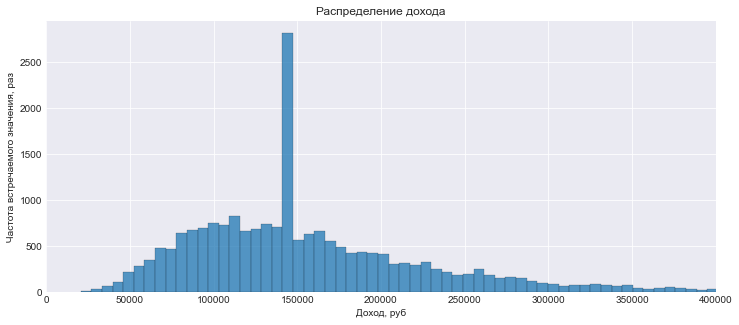

In [58]:
plt.subplots(figsize=(12,5))
# Строим гистограмму для столбца total_income, добавив график кривой KDE
sns.histplot(x='total_income', data=df)
# ограничиваем ось X для наглядности
plt.xlim(0, 400000)
# указываем заголовок графика и подписи осей
plt.title('Распределение дохода')
plt.xlabel('Доход, руб')
plt.ylabel('Частота встречаемого значения, раз')
plt.grid();

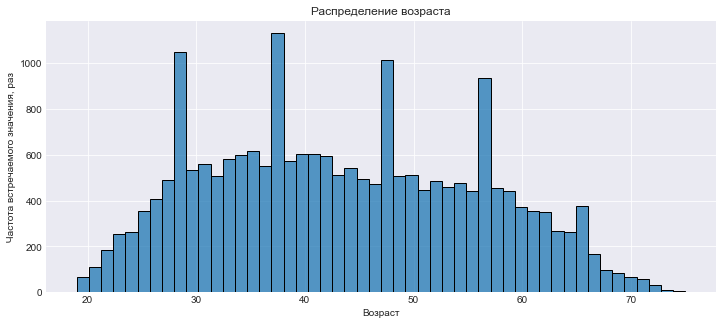

In [59]:
plt.subplots(figsize=(12,5))
# Строим гистограмму для столбца total_income, добавив график кривой KDE
sns.histplot(x='dob_years', data=df, bins=50)
# указываем заголовок графика и подписи осей
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Частота встречаемого значения, раз')
plt.grid();

**Вывод**

Что касается распределений, то по доходу есть явный всплеск, выбивающийся из общей массы. Это означает, что наибольшую зарплату, которую получают люди приблизительно равна 140-145 тыс. руб. 

Глядя на распределение возраста, то и здесь видны всплески в данных, но уже в большем объёме: наиболее часто встречаются люди в возрасте примерно 29, 38, 48, 57 лет. 

### 3.3. Проверка гипотез

#### Гипотеза 1: чем больше детей в семье, тем меньше вероятность возврата кредита в срок

In [60]:
pivot_children = df.pivot_table(index='children', values='debt', aggfunc=['sum', 'count', 'mean'])
pivot_children.columns = ['cnt_debtors', 'total_cnt', 'share_debtors, %']
pivot_children['share_debtors, %'] = pivot_children['share_debtors, %'] * 100
pivot_children.sort_values(by='share_debtors, %', ascending=False)

,cnt_debtors,total_cnt,"share_debtors, %"
children,,,
4,4,41,9.76
2,194,2039,9.51
1,442,4840,9.13
3,27,328,8.23
0,1058,14037,7.54
5,0,9,0.00


**Вывод по гипотезе 1**

Зависимость между количеством детей в семье и возвратом кредита в срок действительно прослеживается. Заёмщики, которые не имеют ни одного ребёнка склонны не возвращать кредит не так сильно, как это прослеживается у заёмщиков, которые имеют от 1 до 4 детей. 

Что касается тех, у кого 5 детей в семье, то здесь, скорее всего, играет роль тот факт, что таких семей в России совсем не много, а если такие и есть, то они не спешат кредитоваться (возможно, такие семьи больше рассчитывают на гос. поддержку в виде различных выплат и предоставлении льгот), поэтому в данном случае доля таких заёмщиков равна нулю. 

Теперь посмотрим на то, как с ростом количества детей меняется количество взятых кредитов, а также количество задолженников

In [61]:
columns_pivot = ['total_cnt', 'cnt_debtors']
labels = [
    ['Количество взятых кредитов, шт.', 'Зависимость количества взятых кредитов от количества детей'],
    ['Количество задолженников, чел', 'Зависимость количества задолженников от количества детей']
         ]
def plotting_line(data_frame):
    labels_dict = dict(zip(columns_pivot, labels))
    plt.figure(figsize=(20, 5))
    for i, column in enumerate(columns_pivot):
        sns.lineplot(x=data_frame.index, y=column, data=data_frame, ax=plt.subplot(1, 2, i + 1))
        plt.xlabel('Количество детей, чел.')
        plt.ylabel(labels_dict[column][0])
        plt.title(labels_dict[column][1])
        plt.grid()

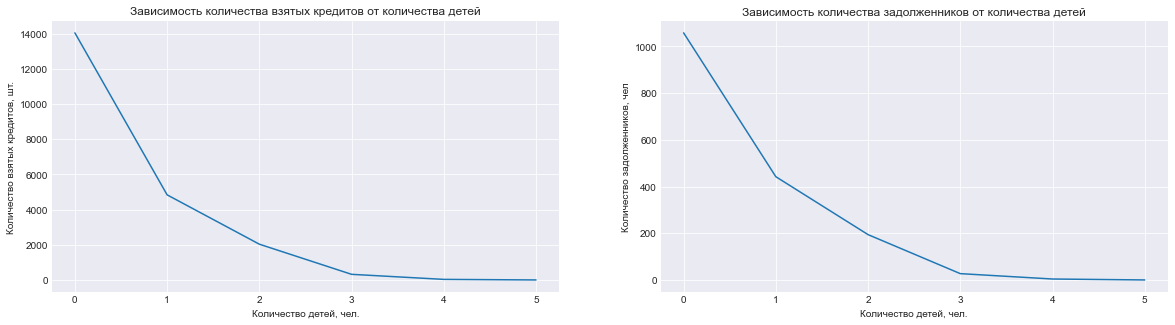

In [62]:
plotting_line(pivot_children)

**Вывод**

По первому графику видно, как падает число выданных кредитов в зависимости от числа детей в семье заёмщика, ровно такая же картина наблюдается и на втором графике. Возможно, это не связано с тем, что многодетные семьи реже берут кредиты или с большей вероятностью возвращают кредит в срок. Скорее всего, семей без детей или с 1–2 детьми намного больше, чем многодетных. В таком случае для полного и объективного понимания всей картины стоит ориентироваться на относительные величины.

#### Гипотеза 2: люди, проживающие в браке, имеют вероятность не вернуть кредит в срок больше, чем люди, которые не проживают в браке

In [63]:
pivot_family_status = df.pivot_table(index='family_status_id', values='debt', aggfunc=['sum', 'count', 'mean'])
pivot_family_status.columns = ['cnt_debtors', 'total_cnt', 'share_debtors, %']
pivot_family_status['share_debtors, %'] = pivot_family_status['share_debtors, %'] * 100
pivot_family_status = pivot_family_status.sort_values(by='share_debtors, %', ascending=False)
pivot_family_status.merge(family_status_dict, on='family_status_id', how='left')

,family_status_id,cnt_debtors,total_cnt,"share_debtors, %",family_status
0,4,272,2785,9.77,не женат / не замужем
1,1,383,4129,9.28,гражданский брак
2,0,924,12247,7.54,женат / замужем
3,3,84,1183,7.10,в разводе
4,2,62,950,6.53,вдовец / вдова


**Вывод по гипотезе 2**

Что касается зависимости семейного положения и возврата кредита в срок, то больше всего должниками являются те, кто не состоит в браке. На втором месте те, кто состоят в гражданском браке. И на третьем - уже те, кто женат/замужем. 

Могу связать это с тем, что, когда у людей начинаются появляться дополнительные обязанности в роде официальной, зарегистрированной семьи, человек начинает вести себя более осторожно с финансами и не спешит влезать в кредиты. 

#### Гипотеза 3: чем ниже уровнь дохода, тем ниже веростность возврата кредита в срок

In [64]:
pivot_income_category = df.pivot_table(index='total_income_category', 
                                       values='debt', 
                                       aggfunc=['sum', 'count', 'mean'])
pivot_income_category.columns = ['cnt_debtors', 'total_cnt', 'share_debtors, %']
pivot_income_category['share_debtors, %'] = pivot_income_category['share_debtors, %'] * 100
pivot_income_category['income_group'] = ['доход от 1000001 и выше', 'доход от 200001 до 1000000', 
                                         'доход от 50001 до 200000', 'доход от 30001 до 50000', 
                                         'доход от 0 до 30000']
pivot_income_category.sort_values(by='share_debtors, %', ascending=False)

,cnt_debtors,total_cnt,"share_debtors, %",income_group
total_income_category,,,,
E,2,22,9.09,доход от 0 до 30000
C,1347,15905,8.47,доход от 50001 до 200000
A,2,25,8.00,доход от 1000001 и выше
B,353,4994,7.07,доход от 200001 до 1000000
D,21,348,6.03,доход от 30001 до 50000


**Вывод по гипотезе 3**

Что касается зависимости дохода и возврата кредита в срок, то здесь прослеживается следующая тенденция: в срок выплатить не могут, и как следствие, попадают в должники те, у кого ежемесячный доход очень низкий. 

Однако люди, у которых доход составляет более 1 млн. рублей, тоже берут кредиты, хоть и количество таких совсем не большое, относительно людей в категориях `B`, `C` и `D`. Скорее всего, это вызвано тем, что такие люди имеют своё дело, а бизнес требует постоянных вложений, но своих средств не всегда хватает, так как большинство денег находятся в обороте, следовательно, они идут в банк за кредитом.

Теперь проанализируем, влияет ли образование на уровень дохода и наличие задолженности

In [65]:
# Создаём датафрейм с данными
data_edu = df.groupby(['education_id', 'debt'], as_index=False)[['total_income']].median()
# Из словаря подтягиваем нужные значения, которые соответствуют ключу education_id
data_edu = data_edu.merge(education_dict, on='education_id', how='left')
# Предобрабатываем колонку debt, делая её более читабельной
data_edu['debt'] = data_edu['debt'].apply(lambda x: 'должник' if x == 1 else 'не должник')

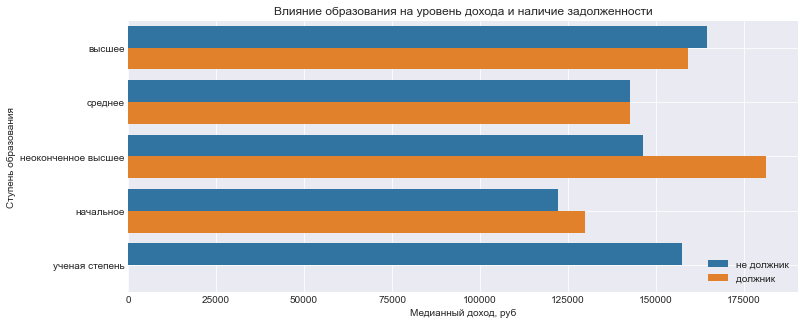

In [66]:
# Строим график
plt.figure(figsize=(12, 5))
# строим столбчатый график средствами seaborn
sns.barplot(x='total_income', y='education', data=data_edu, hue='debt')
plt.title('Влияние образования на уровень дохода и наличие задолженности')
plt.xlabel('Медианный доход, руб')
plt.ylabel('Ступень образования')
# выбираем положение легенды и указываем размер шрифта
plt.legend(loc='lower right', fontsize=10)
plt.grid();

**Вывод**

Должниками бывают люди с любой степенью образования. Однако среди людей с учёной степенью должников нет вообще. Также видим, что среди всех людей наивысший медианных доход у тех, кто имеет неоконченное высшее образование, более того, это прослеживается среди должников. Наименьший медианный доход - среди людей с начальной степенью образования, но только уже среди тех, кто не является должником. 

#### Гипотеза 4: разные цели кредита по-разному влияют на его возврат в срок

In [67]:
pivot_purpose_category = df.pivot_table(index='purpose_category', values='debt', aggfunc=['sum','count', 'mean'])
pivot_purpose_category.columns = ['cnt_debtors', 'total_cnt', 'share_debtors, %']
pivot_purpose_category['share_debtors, %'] = pivot_purpose_category['share_debtors, %'] * 100
pivot_purpose_category.sort_values(by='share_debtors, %', ascending=False)

,cnt_debtors,total_cnt,"share_debtors, %"
purpose_category,,,
операции с автомобилем,398,4271,9.32
получение образования,369,3981,9.27
проведение свадьбы,181,2312,7.83
операции с недвижимостью,471,6308,7.47
покупка жилья,306,4422,6.92


**Вывод по гипотезе 4**

Что касается целей кредита, то мы можем увидеть, что люди, которые берут деньги на операции с автомобилем, больше являются задолжниками. Это можно связать с тем, что в целом машины стоят немало, так еще и простое обслуживание автомобиля обходится совсем не дёшево. 

Проанализируем цели получения кредита

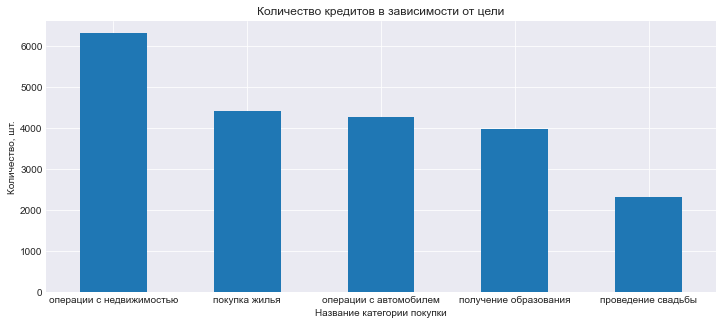

In [68]:
(df.pivot_table(index='purpose_category', values='purpose', aggfunc='count')
   .sort_values(by='purpose', ascending=False)
   .plot(kind='bar', figsize=(12, 5), grid=True, legend=False)
)
plt.title('Количество кредитов в зависимости от цели')
plt.xlabel('Название категории покупки')
plt.ylabel('Количество, шт.')
plt.xticks(rotation=360);

**Вывод**

Наиболее частой целью кредита являются операции с недвижимостью: подавляющее большинство денег берётся именно для этого. 

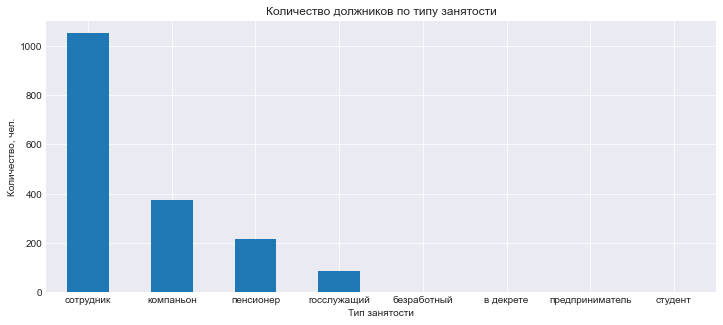

In [69]:
(df.groupby('income_type')[['debt']].sum()
                                    .sort_values(by='debt', ascending=False)
                                    .plot(kind='bar', figsize=(12, 5), grid=True, legend=False)
)
plt.title('Количество должников по типу занятости')
plt.xlabel('Тип занятости')
plt.ylabel('Количество, чел.')
plt.xticks(rotation=360);

**Вывод**

Среди всех категорий сотрудники компаний намного чаще бывают должниками, чем остальные люди, относящиеся к другим типам занятости

Сравним доход у должников и ответственных заёмщиков

In [70]:
# Для столбца debt проделаем аналогичную предобработку, что и выше, но уже для исходного датафрейма
df['debt'] = df['debt'].apply(lambda x: 'должник' if x == 1 else 'не должник')

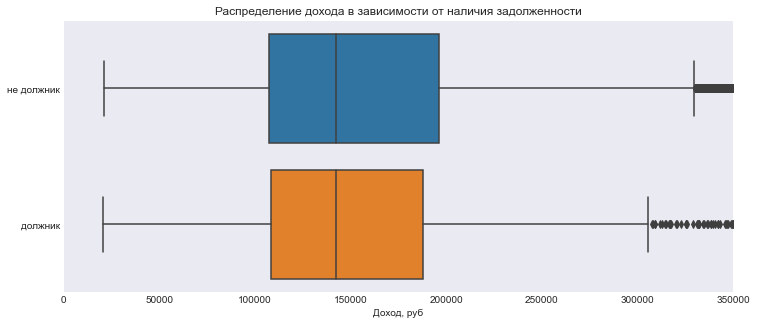

In [71]:
# Строим график
plt.figure(figsize=(12, 5))
sns.boxplot(x='total_income', y='debt', data=df)
plt.xlim(0, 350000)
plt.title('Распределение дохода в зависимости от наличия задолженности')
plt.xlabel('Доход, руб')
plt.ylabel(None);

**Вывод**

Распределение дохода среди должников и не должников сильно похоже друг на друга, единственное, среди не должников скошенность данных больше в правую сторону, а также сам ящик немного длиннее, что говорит о том, что основное скопление данных находится в чуть большем диапазоне. 

Посмотрим на то, как задолженность проявляется среди мужчин и женщин

In [72]:
df['gender'] = df['gender'].apply(lambda x: 'женщина' if x == 'F' else 'мужчина')

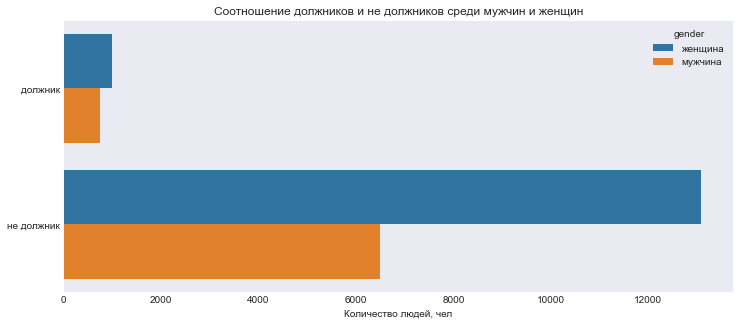

In [73]:
df_gen = df.groupby(['debt', 'gender'], as_index=False)[['education_id']].count()
plt.figure(figsize=(12, 5))
sns.barplot(x='education_id', y='debt', data=df_gen, hue='gender')
plt.title('Соотношение должников и не должников среди мужчин и женщин')
plt.xlabel('Количество людей, чел')
plt.ylabel(None);

**Вывод**

Среди должников женщин прослеживается чуть больше, чем мужчин. Но также и среди не должников женщин больше, только уже различия существенные. 

## 4. Итоговый вывод

После проверки четырёх гипотез было установлено:
1. Чем больше детей в семье, тем меньше вероятность возврата кредита в срок

Данная зависимость действительно прослеживается, так как наибольшую долю должников имеют те семьи, в которых 4 и 2 ребёнка. 

2. Люди, проживающие в браке, имеют вероятность не вернуть кредит в срок больше, чем люди, которые не проживают в браке

Гипотеза не подтвердилась, так как наибольшую долю должников видим у тех, кто либо не женат/не замужем, либо находится в гражданском браке, но это также не является официальным союзом семьи. 

3. Чем ниже уровнь дохода, тем ниже веростность возврата кредита в срок

Данную версию можно подтвердить лишь от части, так как люди, входящие в категорию с самой низкой зарплатой, имеют наибольшую долю должников, однако стоит заметить, что те, кто входит в категорию D (доход от 31 000 до 50 000), имеют наименьшую долю задолженников, поэтому здесь не совсем однозначно. 

4. Разные цели кредита по-разному влияют на его возврат в срок

Здесь можем частично принять гипотезу, так как из пяти представленных целей получения кредита, первые две имеют очень похожую долю задолженников, третья и четвёртая цели тоже имеют похожую долю, но уже в меньшей мере. 

Кроме этого, обнаружены некоторые дополнительные моменты:
- Наиболее популярная цель кредита связана с операциями с недвижимостью
- Подавляющее количество должников прослеживается среди сотрудников каких-либо компаний
- Распределение дохода среди должников и не должников отличается не существенно
- Мужчины чуть меньше склонны к статусы задолженников